In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc as misc
import segmentation_model

%matplotlib inline

RESIZE_DIM=128

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('model_dir', 'segmentation_train',
                           """Directory where model is stored.""")
tf.app.flags.DEFINE_string('image_file', 
                           '/Users/xuehan.xiong/Google Drive/datasets/selfies_segmentation/selfies/w_w_0116.jpg',
                           """Absolute path to image file.""")

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
        
def resize_image(image):
    height,width = image.shape[:2]
    scale = float(RESIZE_DIM) / float(np.minimum(width,height))
    resized_image = cv2.resize(image,(0,0),fx=scale,fy=scale)
    assert np.minimum(resized_image.shape[0],resized_image.shape[1]) == RESIZE_DIM
    return resized_image

def preprocess(image):
    image = np.float32(image)
    image = image * (1. / 255) - 0.5
    return image

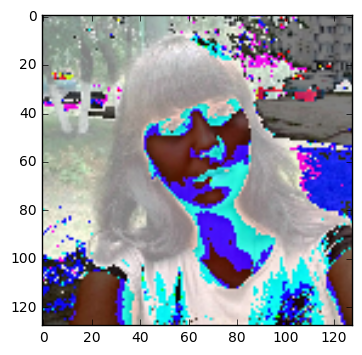

In [3]:
image = FLAGS.image_file;
if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
image_data = misc.imread(image)
# in case of 4-channel image, remove the alpha channel
if image_data.shape[2] > 3:
    image_data = image_data[:,:,:3]
resized_image = resize_image(image_data)
resized_image = preprocess(resized_image)
assert resized_image.shape[2] == 3
height,width = resized_image.shape[:2]
resized_image = np.reshape(resized_image,(1,height,width,3))
plt.imshow(resized_image[0,:,:,:])
plt.show()

In [8]:
#image_data_node = tf.placeholder(tf.float32,
#                                shape=(1, height, width, 3))
images = tf.constant(1.0,shape=[10,128,128,3],dtype=tf.float32)
is_train = tf.placeholder(tf.bool)

scores = segmentation_model.inference(images, is_train)
_,labels = tf.nn.top_k(scores, k=1, sorted=False)
squeezed_labels = tf.squeeze(labels)
    
saver = tf.train.Saver()

sess = tf.Session()
# Restore variables from disk.
saver.restore(sess, os.path.join(FLAGS.model_dir,'model.ckpt-1499'))
print("Model restored.")

labels_val = sess.run(squeezed_labels,feed_dict={is_train:False})
sess.close()

NotFoundError: Tensor name "fc_1/Variable_1" not found in checkpoint files segmentation_train/model.ckpt-1499
	 [[Node: save_1/RestoreV2_53 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_53/tensor_names, save_1/RestoreV2_53/shape_and_slices)]]

Caused by op u'save_1/RestoreV2_53', defined at:
  File "/usr/local/Cellar/python/2.7.12_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipython-5.1.0-py2.7.egg/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/ipython-5.1.0-py2.7.egg/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/ipython-5.1.0-py2.7.egg/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-f95402fc328a>", line 10, in <module>
    saver = tf.train.Saver()
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/training/saver.py", line 1079, in __init__
    self.build()
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/training/saver.py", line 1108, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/training/saver.py", line 706, in build
    restore_sequentially, reshape)
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/training/saver.py", line 443, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/training/saver.py", line 282, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/ops/gen_io_ops.py", line 439, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/framework/ops.py", line 2388, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/xuehan.xiong/framework/tensorflow/_python_build/tensorflow/python/framework/ops.py", line 1300, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "fc_1/Variable_1" not found in checkpoint files segmentation_train/model.ckpt-1499
	 [[Node: save_1/RestoreV2_53 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_53/tensor_names, save_1/RestoreV2_53/shape_and_slices)]]


In [7]:
for op in graph.get_operations():
    print op.name

import/Variable/initial_value
import/Variable
import/Variable/Assign
import/Variable/read
import/input_producer/Const
import/input_producer/Size
import/input_producer/Greater/y
import/input_producer/Greater
import/input_producer/Assert/AssertGuard/Switch
import/input_producer/Assert/AssertGuard/switch_t
import/input_producer/Assert/AssertGuard/switch_f
import/input_producer/Assert/AssertGuard/pred_id
import/input_producer/Assert/AssertGuard/NoOp
import/input_producer/Assert/AssertGuard/control_dependency
import/input_producer/Assert/AssertGuard/Assert/data_0
import/input_producer/Assert/AssertGuard/Assert/Switch
import/input_producer/Assert/AssertGuard/Assert
import/input_producer/Assert/AssertGuard/control_dependency_1
import/input_producer/Assert/AssertGuard/Merge
import/input_producer/Identity
import/input_producer/RandomShuffle
import/input_producer
import/input_producer/input_producer_EnqueueMany
import/input_producer/input_producer_Close
import/input_producer/input_producer_Close